# Combining Image Classification and NLP Models Together

## Import Libraries

In [1]:
# change the python's path to the parent directory
import sys
sys.path.append("../")

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import gc
import numpy as np

from models.popular_models import PopularModels
from models.lstm import LSTM
from torchvision import transforms
from tqdm import tqdm
from data.dataset import MultiLabelDataset
from tools.tools import get_data, load_data, tokenize, remove_class, count_class, calculate_pos_weights
from torch.utils.data import DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

/home/reynardo/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Remove unused memory in GPU

In [3]:
gc.collect()
torch.cuda.empty_cache()

## Load the Data

In [4]:
# import data
train_data = get_data("../dataset/train.csv")
test_data = get_data("../dataset/test.csv")

# perform text cleaning and get the pandas' dataframe
train_data = load_data(train_data)
test_data = load_data(test_data, has_label=False)

# remove an imbalanced class
train_data = remove_class(train_data, class_no=1)

# split into training and validating sets
X = train_data.iloc[:, 0:2]
y = train_data.iloc[:, 2:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

train_data = pd.concat([X_train, y_train], axis=1)
val_data = pd.concat([X_test, y_test], axis=1)

# join the data together
for_nlp_data = pd.concat((train_data['caption'], val_data['caption'], test_data['caption']), ignore_index=True)

In [5]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(12740, 21)
(3185, 21)
(10000, 2)


In [6]:
print(f"Number of training instances: 	{train_data.shape[0]}")
print(f"Number of validation instances: {val_data.shape[0]}")
print(f"Number of testing instances:  	{test_data.shape[0]}")

Number of training instances: 	12740
Number of validation instances: 3185
Number of testing instances:  	10000


## Preprocessing for Images and Caption

In [7]:
# define the image transformation: currently following resnet18
transform = transforms.Compose([
	transforms.Resize((232, 232)),
	transforms.CenterCrop(224),
	transforms.ToTensor(), # converts images to [0, 1]
	transforms.Normalize(
		mean=[0.485, 0.456, 0.406],
		std=[0.229, 0.224, 0.225],
	)
])

# tokenize the data
final_list, vocab = tokenize(for_nlp_data)
X_train_vec = final_list[:train_data.shape[0], :]
X_val_vec = final_list[train_data.shape[0]:train_data.shape[0]+val_data.shape[0], :]
X_test_vec = final_list[train_data.shape[0]+val_data.shape[0]:, :]

print(final_list.shape)
print(X_train_vec.shape)
print(X_val_vec.shape)
print(X_test_vec.shape)

Max Sentence Length: 28
(25925, 28)
(12740, 28)
(3185, 28)
(10000, 28)


## Create Dataset and DataLoader

In [8]:
# initialize the dataset
train_dataset = MultiLabelDataset(
	csv_file=train_data,
	root_dir='../dataset/data/',
	vectorizer=None,
	transform=transform,
	use_caption_vec=True,
	caption_vec=X_train_vec,
	is_test=False,
)
val_dataset = MultiLabelDataset(
    csv_file=val_data,
    root_dir='../dataset/data/',
    vectorizer=None,
	transform=transform,
	use_caption_vec=True,
	caption_vec=X_val_vec,
	is_test=False,
)
test_dataset = MultiLabelDataset(
	csv_file=test_data,
	root_dir='../dataset/data/',
	vectorizer=None,
	transform=transform,
	use_caption_vec=True,
	caption_vec=X_test_vec,
	is_test=True,
)

BATCH_SIZE=16

# load the dataset into batches 
train_dataloader = DataLoader(
	dataset=train_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
)
val_dataloader = DataLoader(
    dataset=val_dataset,
	batch_size=BATCH_SIZE,
	shuffle=True,
)
test_dataloader = DataLoader(
	dataset=test_dataset,
	batch_size=BATCH_SIZE,
	shuffle=False,
)

## Create the Combined Model

In [9]:
class CombinedModel(nn.Module):

	def __init__(
			self, 
			choice: str, 
			pretrained: bool, 
			freeze: bool, 
			cnn_n_out: int,
			no_layers: int,
			vocab_size: int,
			embedding_dim: int,
			lstm_hidden_dim: int,
			lstm_n_out: int,
			lstm_dropout: float = 0.5,
			fc_dropout: float = 0.5,
		) -> None:
		super(CombinedModel, self).__init__()

		# get the CNN model for image classification
		self.cnn_model = PopularModels(
			choice=choice,
			pretrained=pretrained,
			freeze=freeze,
			n_out=cnn_n_out,
		).get_model()

		# get the LSTM model for text classification
		self.lstm_model = LSTM(
			no_layers=no_layers,
			vocab_size=vocab_size + 1,
			embedding_dim=embedding_dim,
			hidden_dim=lstm_hidden_dim,
			output_dim=lstm_n_out,
			dropout=lstm_dropout,
		)
		
		# create the final fully connected layer
		self.last_layer = nn.Linear(cnn_n_out + lstm_n_out, 19)
		
		# prevent overfitting
		self.dropout_layer = nn.Dropout(p=fc_dropout, inplace=True)

	def forward(self, x, y, hidden):
		x = self.cnn_model(x)
		y, hidden = self.lstm_model(y, hidden)
		
		output = torch.cat((x, y), dim=1)
		output = self.dropout_layer(output)
		output = self.last_layer(output)

		return output, hidden

## Define the model

In [10]:
class_counts = list(count_class(train_data).values())
pos_weights = calculate_pos_weights(class_counts, train_data)
if torch.cuda.is_available():
	pos_weights = pos_weights.to('cuda')

In [11]:
EPOCHS = 20
THRESHOLD = 0.7
N_CLASSES = 19

model = CombinedModel(
	choice="regnet_x_1_6gf",
	pretrained=True, 		# if pretrained is False, then freeze should also be False
	freeze=True,
	cnn_n_out=256,
	no_layers=2,
	vocab_size=len(vocab), 	# already added by 1
	embedding_dim=64,
	lstm_hidden_dim=256,
	lstm_n_out=128,
	lstm_dropout=0,
	fc_dropout=0,
)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
optimizer = torch.optim.Adam(
	params=model.parameters(),
	lr=0.001,
)

# utilise GPU
if torch.cuda.is_available():
	print('using GPU')
	model = model.to('cuda')

using GPU


## Train the model

In [12]:
clip = 5 # for exploding gradient problem
train_losses = []
train_accs = []
sk_val_accs = []
sk_train_accs = []
for epoch in range(EPOCHS):

	# initialize the hidden state
	hidden = model.lstm_model.init_hidden(batch_size=BATCH_SIZE)

	start = 0 # index
	y_true = np.zeros((train_data.shape[0], N_CLASSES))
	y_preds = np.zeros((train_data.shape[0], N_CLASSES))
	n_total = 0
	n_correct = 0
	train_loss = 0.
	model.train()
	for image_names, images, captions, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1} Training: "):

		if torch.cuda.is_available():
			images = images.to('cuda')
			captions = captions.to('cuda')
			labels = labels.to('cuda')
		
		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		hidden = tuple([each.data for each in hidden])

		optimizer.zero_grad()
		y_pred, hidden = model(images, captions, hidden)

		# backward
		loss = loss_fn(y_pred, labels)
		loss.backward()

		# clip_grad_norm helps prevent the exploding gradient problem in RNNs/LSTMs
		nn.utils.clip_grad_norm_(model.parameters(), clip)

		# update
		optimizer.step()

		# compare
		predicted = (F.sigmoid(y_pred) > THRESHOLD).int()

		n = images.shape[0]
		y_true[start:start+n] = labels.cpu().numpy()
		y_preds[start:start+n] = predicted.cpu().numpy()
		start = start + n

		train_loss += loss.item()
		n_correct += torch.all(torch.eq(predicted, labels), dim=1).sum()
		n_total += labels.shape[0]

	train_losses.append(train_loss / len(train_dataloader))
	train_accs.append(n_correct / n_total)
	sk_train_accs.append(accuracy_score(y_true, y_preds))

	print("Epoch {:d}, Train Loss: {:.9f}, Train Accuracy: {:.7f}%".format(epoch+1, 
																		train_losses[-1], 
																		accuracy_score(y_true, y_preds)*100), end="")
	
	# initialize the hidden state
	val_hidden = model.lstm_model.init_hidden(batch_size=BATCH_SIZE)

	start = 0 # index
	y_true = np.zeros((val_data.shape[0], N_CLASSES))
	y_preds = np.zeros((val_data.shape[0], N_CLASSES))
	model.eval()
	for (_, images, captions, labels) in val_dataloader:

		# creating new variables for the hidden state, otherwise
		# we'd backprop through the entire training history
		val_hidden = tuple([each.data for each in val_hidden])
		
		if torch.cuda.is_available():
			images = images.to('cuda')
			captions = captions.to('cuda')
			labels = labels.to('cuda')
		
		outputs, _ = model(images, captions, val_hidden)
		predicted = (F.sigmoid(outputs) > THRESHOLD).int()

		n = images.shape[0]
		y_true[start:start+n] = labels.cpu().numpy()
		y_preds[start:start+n] = predicted.cpu().numpy()
		start = start + n
	
	sk_val_accs.append(accuracy_score(y_true, y_preds))
	print("\tVal Accuracy: {:.7f}%".format(accuracy_score(y_true, y_preds)*100))

Epoch 1 Training: 100%|██████████| 797/797 [00:52<00:00, 15.17it/s]


Epoch 1, Train Loss: 0.747995133, Train Accuracy: 14.3014129%	Val Accuracy: 21.7896389%


Epoch 2 Training: 100%|██████████| 797/797 [00:52<00:00, 15.26it/s]


Epoch 2, Train Loss: 0.637372481, Train Accuracy: 19.0894819%	Val Accuracy: 25.0235479%


Epoch 3 Training: 100%|██████████| 797/797 [00:52<00:00, 15.10it/s]


Epoch 3, Train Loss: 0.571555710, Train Accuracy: 22.6059655%	Val Accuracy: 27.9434851%


Epoch 4 Training: 100%|██████████| 797/797 [00:52<00:00, 15.18it/s]


Epoch 4, Train Loss: 0.530594808, Train Accuracy: 24.9136578%	Val Accuracy: 27.9748823%


Epoch 5 Training: 100%|██████████| 797/797 [00:52<00:00, 15.13it/s]


Epoch 5, Train Loss: 0.486675895, Train Accuracy: 26.6405024%	Val Accuracy: 31.5855573%


Epoch 6 Training: 100%|██████████| 797/797 [00:52<00:00, 15.29it/s]


Epoch 6, Train Loss: 0.459753255, Train Accuracy: 27.8963893%	Val Accuracy: 31.8367347%


Epoch 7 Training: 100%|██████████| 797/797 [00:52<00:00, 15.09it/s]


Epoch 7, Train Loss: 0.423219732, Train Accuracy: 29.3092622%	Val Accuracy: 30.6436421%


Epoch 8 Training: 100%|██████████| 797/797 [00:52<00:00, 15.22it/s]


Epoch 8, Train Loss: 0.399483617, Train Accuracy: 30.6514914%	Val Accuracy: 32.4646782%


Epoch 9 Training: 100%|██████████| 797/797 [00:52<00:00, 15.15it/s]


Epoch 9, Train Loss: 0.363181516, Train Accuracy: 33.6028257%	Val Accuracy: 32.3390895%


Epoch 10 Training: 100%|██████████| 797/797 [00:52<00:00, 15.26it/s]


Epoch 10, Train Loss: 0.330392322, Train Accuracy: 35.2354788%	Val Accuracy: 32.4018838%


Epoch 11 Training: 100%|██████████| 797/797 [00:52<00:00, 15.04it/s]


Epoch 11, Train Loss: 0.308158069, Train Accuracy: 37.0251177%	Val Accuracy: 33.4379906%


Epoch 12 Training: 100%|██████████| 797/797 [00:52<00:00, 15.13it/s]


Epoch 12, Train Loss: 0.280136377, Train Accuracy: 39.2621664%	Val Accuracy: 34.2229199%


Epoch 13 Training: 100%|██████████| 797/797 [00:52<00:00, 15.12it/s]


Epoch 13, Train Loss: 0.263209036, Train Accuracy: 40.3846154%	Val Accuracy: 36.0439560%


Epoch 14 Training: 100%|██████████| 797/797 [00:52<00:00, 15.28it/s]


Epoch 14, Train Loss: 0.241321156, Train Accuracy: 42.2762951%	Val Accuracy: 35.0078493%


Epoch 15 Training: 100%|██████████| 797/797 [00:52<00:00, 15.26it/s]


Epoch 15, Train Loss: 0.219401173, Train Accuracy: 44.4583987%	Val Accuracy: 33.7833595%


Epoch 16 Training: 100%|██████████| 797/797 [00:52<00:00, 15.23it/s]


Epoch 16, Train Loss: 0.205463350, Train Accuracy: 45.7770801%	Val Accuracy: 35.0078493%


Epoch 17 Training: 100%|██████████| 797/797 [00:52<00:00, 15.17it/s]


Epoch 17, Train Loss: 0.194049203, Train Accuracy: 47.3940345%	Val Accuracy: 34.8822606%


Epoch 18 Training: 100%|██████████| 797/797 [00:52<00:00, 15.19it/s]


Epoch 18, Train Loss: 0.180857333, Train Accuracy: 48.3124019%	Val Accuracy: 36.1067504%


Epoch 19 Training: 100%|██████████| 797/797 [00:53<00:00, 15.04it/s]


Epoch 19, Train Loss: 0.171881274, Train Accuracy: 50.1805338%	Val Accuracy: 34.1915228%


Epoch 20 Training: 100%|██████████| 797/797 [00:51<00:00, 15.36it/s]


Epoch 20, Train Loss: 0.162499706, Train Accuracy: 51.2009419%	Val Accuracy: 32.3390895%


## Graphs and Evaluation

In [13]:
import matplotlib.pyplot as plt

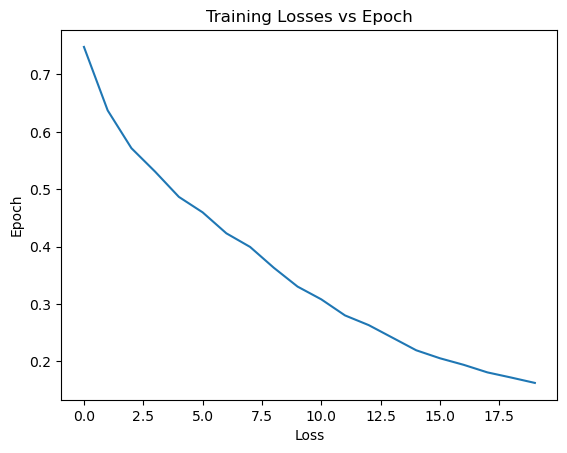

In [14]:
plt.title("Training Losses vs Epoch")
plt.plot(train_losses)
plt.ylabel("Epoch")
plt.xlabel("Loss")
plt.show()

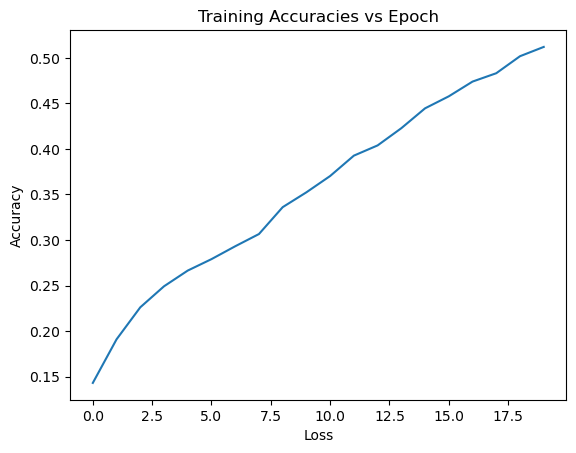

In [15]:
new_train_accs = []
for train_acc in train_accs:
    new_train_accs.append(train_acc.item())

plt.title("Training Accuracies vs Epoch")
plt.plot(new_train_accs)
plt.ylabel("Accuracy")
plt.xlabel("Loss")
plt.show()

## Save, Test and Load Model

In [16]:
torch.save(model.state_dict(), '../combined_model_1.pth')

In [17]:
model = CombinedModel(
	choice="regnet_x_1_6gf",
	pretrained=True, 		# if pretrained is False, then freeze should also be False
	freeze=True,
	cnn_n_out=256,
	no_layers=2,
	vocab_size=len(vocab), 	# already added by 1
	embedding_dim=64,
	lstm_hidden_dim=256,
	lstm_n_out=128,
)
model.load_state_dict(torch.load('../combined_model_1.pth'))

<All keys matched successfully>

In [18]:
# create a file for test submission
f = open('../submission_combined.csv', "w")
f.write("ImageID,Labels\n")

# utilise GPU
if torch.cuda.is_available():
	print('using GPU')
	model = model.to('cuda')

# initialize the hidden state
hidden = model.lstm_model.init_hidden(batch_size=BATCH_SIZE)

# idx = 0
model.eval()
for (image_names, images, captions) in test_dataloader:

	# creating new variables for the hidden state, otherwise
	# we'd backprop through the entire training history
	hidden = tuple([each.data for each in hidden])
	
	if torch.cuda.is_available():
		images = images.to('cuda')
		captions = captions.to('cuda')
	
	outputs, _ = model(images, captions, hidden)
	predicted = (F.sigmoid(outputs) > THRESHOLD).int()

	# NOTE: add 1 to the output of predicted!
	# write the output
	for i, predicted_label in enumerate(predicted):
		label = (predicted_label == torch.max(predicted_label)).nonzero().flatten()
		label += 1
		label = label.tolist()
		label = " ".join(str(x) for x in label)

		f.write(image_names[i].split("/")[-1] + "," + str(label) +"\n")

f.close()

using GPU


In [19]:
# create a file for test submission
f = open('../train_combined.csv', "w")
f.write("ImageID,Labels\n")

# utilise GPU
if torch.cuda.is_available():
	print('using GPU')
	model = model.to('cuda')

# initialize the hidden state
hidden = model.lstm_model.init_hidden(batch_size=BATCH_SIZE)

# idx = 0
model.eval()
for (image_names, images, captions, _) in train_dataloader:

	# creating new variables for the hidden state, otherwise
	# we'd backprop through the entire training history
	hidden = tuple([each.data for each in hidden])
	
	if torch.cuda.is_available():
		images = images.to('cuda')
		captions = captions.to('cuda')
	
	outputs, _ = model(images, captions, hidden)
	predicted = (F.sigmoid(outputs) > THRESHOLD).int()

	# NOTE: add 1 to the output of predicted!
	# write the output
	for i, predicted_label in enumerate(predicted):
		label = (predicted_label == torch.max(predicted_label)).nonzero().flatten()
		label += 1
		label = label.tolist()
		label = " ".join(str(x) for x in label)

		f.write(image_names[i].split("/")[-1] + "," + str(label) +"\n")

f.close()

using GPU
